## Change prior exploration
This notebook tries to find out the reason why CC and PCC seem to work better when there is a change in P(X|Y) that when this change does not exist. This explanation is neccesary because we have this experiment in the paper.

loading /media/nas/pgonzalez/quant_datasetshift/datasets/reviews/Electronics_mini.txt: 100%|██████████| 50000/50000 [00:00<00:00, 915902.89it/s]
loading /media/nas/pgonzalez/quant_datasetshift/datasets/reviews/Books_mini.txt: 100%|██████████| 50000/50000 [00:00<00:00, 883625.26it/s]


1/1 Prior shift: p_train=0.500000. Rep: 0
Tkfid for training...
Transforming test set with same tkfid...
Done. Fitting quantification methods...
Done. Evaluating...
Evaluating quantifier CC
CC with change conditionals
               p_train  p_test  train_acc  test_acc     error
prior_measure                                                
-0.15              0.5    0.35   0.884954  0.798956  0.028721
-0.10              0.5    0.40   0.884954  0.821687  0.019277
-0.05              0.5    0.45   0.884954  0.847682  0.028698
 0.00              0.5    0.50   0.884954  0.813253  0.034137
 0.05              0.5    0.55   0.884954  0.839060  0.030741
 0.10              0.5    0.60   0.884954  0.849117  0.032103
 0.15              0.5    0.65   0.884954  0.850914  0.033755
CC with NO change conditionals
               p_train  p_test  train_acc  test_acc     error
prior_measure                                                
-0.15              0.5    0.35   0.884954  0.832461  0.062827
-0.10  

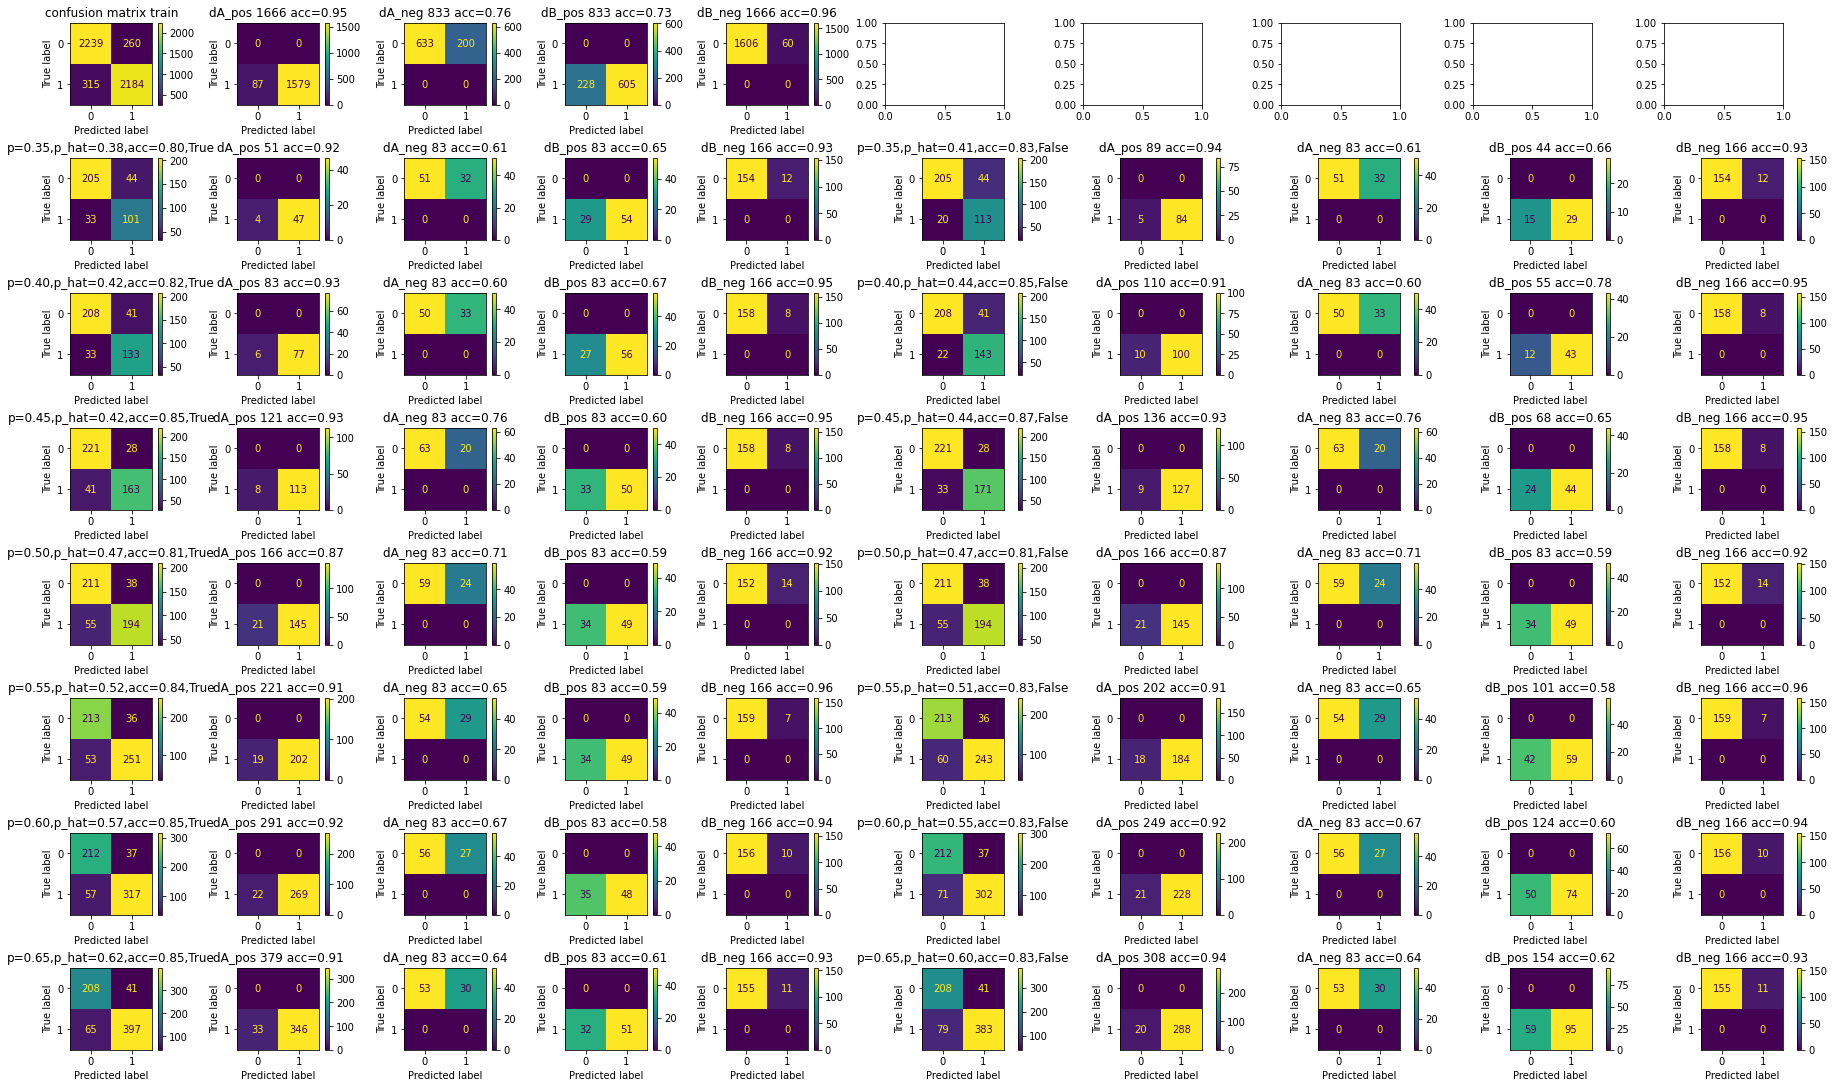

In [14]:
from quapy.data.reader import from_text
from quapy.data.base import LabelledCollection
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from quapy.protocol import APP
from utils.changeprior_protocol import ChangePriorProtocol
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pandas as pd
import quapy as qp
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

def load_data():
    domainA = LabelledCollection.load(os.path.join(base_path, "Electronics_mini.txt"), from_text)
    domainB = LabelledCollection.load(os.path.join(base_path, "Books_mini.txt"), from_text)
    return domainA, domainB

def binarize_dataset(dataset):
    instances = dataset.X
    labels = dataset.y
    labels, instances = labels[labels!=3], instances[labels!=3]
    labels[labels<3] = 0
    labels[labels>3] = 1
    return LabelledCollection(instances, labels)

def create_quant_methods(max_iter):
    return {
        "CC":qp.method.aggregative.CC(LogisticRegression(max_iter=max_iter, class_weight='balanced')),
        # "PCC":qp.method.aggregative.PCC(LogisticRegression(max_iter=max_iter)),
        # "ACC":qp.method.aggregative.ACC(LogisticRegression(max_iter=max_iter), val_split=5, n_jobs=-1),
        # "PACC":qp.method.aggregative.PACC(LogisticRegression(max_iter=max_iter), val_split=5, n_jobs=-1),
        # "HDy":qp.method.aggregative.HDy(LogisticRegression(max_iter=max_iter)),
        # "DyS":qp.method.aggregative.DyS(LogisticRegression(max_iter=max_iter), distance='topsoe',n_bins=10),
        # "SMM":qp.method.aggregative.SMM(LogisticRegression(max_iter=max_iter)),
        # "SLD":qp.method.aggregative.EMQ(CalibratedClassifierCV(LogisticRegression(max_iter=max_iter, class_weight='balanced'),n_jobs=-1)),
        # "MLPE":qp.method.non_aggregative.MaximumLikelihoodPrevalenceEstimation()
    }

def plot_confusion_matrix(true,preds,classes,title,ax=None):
    cm = confusion_matrix(true, preds, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    if ax==None:
        disp.plot()
    else:
        disp.plot(ax=ax)
    disp.ax_.set_title(title)

#Configuration
base_path = "/media/nas/pgonzalez/quant_datasetshift/datasets/reviews"
training_sample_size = 5000
test_sample_size = 500
n_test_samples = 1
n_reps_train = 1
max_iter = 1000
error_function = qp.error.mae
seed = 1

#set numpy seed
np.random.seed(seed)

qp.environ['SAMPLE_SIZE'] = test_sample_size
qp.environ['N_JOBS'] = 1

with qp.util.temp_seed(seed):

    domainA, domainB = load_data()

    domainA = binarize_dataset(domainA)
    domainB = binarize_dataset(domainB)

    domainA_train, domainA_test = domainA.split_stratified(train_prop=0.6, random_state=seed)
    domainB_train, domainB_test = domainB.split_stratified(train_prop=0.6, random_state=seed)

    domainA_test = domainA_test.uniform_sampling(50000, random_state=seed)
    domainB_test = domainB_test.uniform_sampling(50000, random_state=seed)


    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],'class_weight': ['balanced', None]}

    #We want to generate bags with covariate shift for training
    trainSampleGenerator = ChangePriorProtocol(domainA=domainA_train, domainB=domainB_train,change_conditionals=False, sample_size = training_sample_size,prevalences=[0.5], return_type="labelled_collection",repeats=n_reps_train,random_state=seed)

    experiment_results = {}
    quant_methods = create_quant_methods(max_iter)
    for method_name in quant_methods.keys():
        experiment_results[method_name] = pd.DataFrame(columns=["p_train","p_test","n_dA_pos","change_conditionals","train_rep","test_sample","p_hat","train_acc","test_acc","error"])

    for n_training_sample, training_sample in enumerate(trainSampleGenerator()):
        rep = n_training_sample % n_reps_train

        print("%d/%d Prior shift: p_train=%f. Rep: %d" % (n_training_sample+1,n_reps_train,training_sample.prevalence()[1],rep))
        print("Tkfid for training...")
        vectorizer = TfidfVectorizer(min_df=3, sublinear_tf=True)
        vec_documents = vectorizer.fit_transform(training_sample.X)
        print("Transforming test set with same tkfid...")
        trainset = LabelledCollection(vec_documents, training_sample.y)
        trainsplit, valsplit = trainset.split_stratified(train_prop=0.6, random_state=seed)
        testA = LabelledCollection(vectorizer.transform(domainA_test.X),domainA_test.y)
        testB = LabelledCollection(vectorizer.transform(domainB_test.X),domainB_test.y)
        print("Done. Fitting quantification methods...")
        grids = {}
        for quant_name, quantifier in quant_methods.items():
            grids[quant_name] = quantifier.fit(trainsplit)
        #Check how good is the classifier
        predictions_train = grids[quant_name].learner.predict(trainset.X)
        n_dA_pos = trainSampleGenerator.n_dA_pos[0]
        n_dA_neg = trainSampleGenerator.n_dA_neg[0]
        n_dB_pos = trainSampleGenerator.n_dB_pos[0]
        n_dB_neg = trainSampleGenerator.n_dB_neg[0]
        dA_pos_idxs = np.arange(0,n_dA_pos)
        dA_neg_idxs = np.arange(n_dA_pos,n_dA_pos+n_dA_neg)
        dB_pos_idxs = np.arange(n_dA_pos+n_dA_neg,n_dA_pos+n_dA_neg+n_dB_pos)
        dB_neg_idxs = np.arange(n_dA_pos+n_dA_neg+n_dB_pos,n_dA_pos+n_dA_neg+n_dB_pos+n_dB_neg)
        fig, axs = plt.subplots(8, 10,figsize=(25,15),constrained_layout=True)
        plot_confusion_matrix(trainset.y,predictions_train,[0,1],"confusion matrix train",ax=axs[0][0])
        plot_confusion_matrix(training_sample.y[dA_pos_idxs],predictions_train[dA_pos_idxs],[0,1],"dA_pos %d acc=%.2f" % (n_dA_pos,accuracy_score(predictions_train[dA_pos_idxs],trainset.y[dA_pos_idxs])),ax=axs[0][1])
        plot_confusion_matrix(training_sample.y[dA_neg_idxs],predictions_train[dA_neg_idxs],[0,1],"dA_neg %d acc=%.2f" % (n_dA_neg,accuracy_score(predictions_train[dA_neg_idxs],trainset.y[dA_neg_idxs])),ax=axs[0][2])
        plot_confusion_matrix(training_sample.y[dB_pos_idxs],predictions_train[dB_pos_idxs],[0,1],"dB_pos %d acc=%.2f" % (n_dB_pos,accuracy_score(predictions_train[dB_pos_idxs],trainset.y[dB_pos_idxs])),ax=axs[0][3])
        plot_confusion_matrix(training_sample.y[dB_neg_idxs],predictions_train[dB_neg_idxs],[0,1],"dB_neg %d acc=%.2f" % (n_dB_neg,accuracy_score(predictions_train[dB_neg_idxs],trainset.y[dB_neg_idxs])),ax=axs[0][4])
        
        trainaccuracy = accuracy_score(predictions_train,trainset.y)
        print("Done. Evaluating...")   

        

        for quant_name, quantifier in quant_methods.items():
            print("Evaluating quantifier %s" % quant_name)
            testSampleGenerator = ChangePriorProtocol(domainA=testA,domainB=testB,prevalences=np.linspace(0.35,0.65,7), change_conditionals = True, sample_size = test_sample_size,repeats=n_test_samples,return_type="labelled_collection", random_state=seed)
            for n_test_sample, test_sample in enumerate(testSampleGenerator()):
                n_p_value = n_test_sample//n_test_samples
                n_test_sample = n_test_sample % n_test_samples
                #print("p_test = %f, n_dA_pos = %d" % (test_sample[1][1],testSampleGenerator.n_dA_pos[n_p_value]))
                preds = grids[quant_name].quantify(test_sample.X)
                true = test_sample.p
                error = error_function(true,preds)
                predictions_test = grids[quant_name].learner.predict(test_sample.X)
                n_dA_pos = testSampleGenerator.n_dA_pos[n_p_value]
                n_dA_neg = testSampleGenerator.n_dA_neg[n_p_value]
                n_dB_pos = testSampleGenerator.n_dB_pos[n_p_value]
                n_dB_neg = testSampleGenerator.n_dB_neg[n_p_value]
                dA_pos_idxs = np.arange(0,n_dA_pos)
                dA_neg_idxs = np.arange(n_dA_pos,n_dA_pos+n_dA_neg)
                dB_pos_idxs = np.arange(n_dA_pos+n_dA_neg,n_dA_pos+n_dA_neg+n_dB_pos)
                dB_neg_idxs = np.arange(n_dA_pos+n_dA_neg+n_dB_pos,n_dA_pos+n_dA_neg+n_dB_pos+n_dB_neg)
                plot_confusion_matrix(test_sample.y,predictions_test,[0,1],"p=%.2f,p_hat=%.2f,acc=%.2f,True" % (true[1],preds[1],accuracy_score(predictions_test,test_sample.y)),ax=axs[n_p_value+1][0])
                plot_confusion_matrix(test_sample.y[dA_pos_idxs],predictions_test[dA_pos_idxs],[0,1],"dA_pos %d acc=%.2f" % (n_dA_pos,accuracy_score(predictions_test[dA_pos_idxs],test_sample.y[dA_pos_idxs])),ax=axs[n_p_value+1][1])
                plot_confusion_matrix(test_sample.y[dA_neg_idxs],predictions_test[dA_neg_idxs],[0,1],"dA_neg %d acc=%.2f" % (n_dA_neg,accuracy_score(predictions_test[dA_neg_idxs],test_sample.y[dA_neg_idxs])),ax=axs[n_p_value+1][2])
                plot_confusion_matrix(test_sample.y[dB_pos_idxs],predictions_test[dB_pos_idxs],[0,1],"dB_pos %d acc=%.2f" % (n_dB_pos,accuracy_score(predictions_test[dB_pos_idxs],test_sample.y[dB_pos_idxs])),ax=axs[n_p_value+1][3])
                plot_confusion_matrix(test_sample.y[dB_neg_idxs],predictions_test[dB_neg_idxs],[0,1],"dB_neg %d acc=%.2f" % (n_dB_neg,accuracy_score(predictions_test[dB_neg_idxs],test_sample.y[dB_neg_idxs])),ax=axs[n_p_value+1][4])
                experiment_results[quant_name] = experiment_results[quant_name].append([{
                                                        'p_train':trainset.p[1],
                                                        'p_test':test_sample.p[1],
                                                        'train_rep':rep,
                                                        'change_conditionals':True,
                                                        'n_dA_pos':testSampleGenerator.n_dA_pos[n_p_value],
                                                        'test_sample':n_test_sample,
                                                        'p_hat':preds,
                                                        'train_acc':trainaccuracy,
                                                        'test_acc':accuracy_score(predictions_test,test_sample.y),
                                                        'error':error}],ignore_index=True)
            testSampleGenerator = ChangePriorProtocol(domainA=testA,domainB=testB,prevalences=np.linspace(0.35,0.65,7), change_conditionals = False, sample_size = test_sample_size,repeats=n_test_samples,return_type="labelled_collection", random_state=seed)
            for n_test_sample, test_sample in enumerate(testSampleGenerator()):
                n_p_value = n_test_sample//n_test_samples
                n_test_sample = n_test_sample % n_test_samples
                #print("p_test = %f, n_dA_pos = %d" % (test_sample[1][1],testSampleGenerator.n_dA_pos[n_p_value]))
                preds = grids[quant_name].quantify(test_sample.X)
                true = test_sample.p
                error = error_function(true,preds)
                predictions_test = grids[quant_name].learner.predict(test_sample.X)
                n_dA_pos = testSampleGenerator.n_dA_pos[n_p_value]
                n_dA_neg = testSampleGenerator.n_dA_neg[n_p_value]
                n_dB_pos = testSampleGenerator.n_dB_pos[n_p_value]
                n_dB_neg = testSampleGenerator.n_dB_neg[n_p_value]
                dA_pos_idxs = np.arange(0,n_dA_pos)
                dA_neg_idxs = np.arange(n_dA_pos,n_dA_pos+n_dA_neg)
                dB_pos_idxs = np.arange(n_dA_pos+n_dA_neg,n_dA_pos+n_dA_neg+n_dB_pos)
                dB_neg_idxs = np.arange(n_dA_pos+n_dA_neg+n_dB_pos,n_dA_pos+n_dA_neg+n_dB_pos+n_dB_neg)
                plot_confusion_matrix(test_sample.y,predictions_test,[0,1],"p=%.2f,p_hat=%.2f,acc=%.2f,False" % (true[1],preds[1],accuracy_score(predictions_test,test_sample.y)),ax=axs[n_p_value+1][5])
                plot_confusion_matrix(test_sample.y[dA_pos_idxs],predictions_test[dA_pos_idxs],[0,1],"dA_pos %d acc=%.2f" % (n_dA_pos,accuracy_score(predictions_test[dA_pos_idxs],test_sample.y[dA_pos_idxs])),ax=axs[n_p_value+1][6])
                plot_confusion_matrix(test_sample.y[dA_neg_idxs],predictions_test[dA_neg_idxs],[0,1],"dA_neg %d acc=%.2f" % (n_dA_neg,accuracy_score(predictions_test[dA_neg_idxs],test_sample.y[dA_neg_idxs])),ax=axs[n_p_value+1][7])
                plot_confusion_matrix(test_sample.y[dB_pos_idxs],predictions_test[dB_pos_idxs],[0,1],"dB_pos %d acc=%.2f" % (n_dB_pos,accuracy_score(predictions_test[dB_pos_idxs],test_sample.y[dB_pos_idxs])),ax=axs[n_p_value+1][8])
                plot_confusion_matrix(test_sample.y[dB_neg_idxs],predictions_test[dB_neg_idxs],[0,1],"dB_neg %d acc=%.2f" % (n_dB_neg,accuracy_score(predictions_test[dB_neg_idxs],test_sample.y[dB_neg_idxs])),ax=axs[n_p_value+1][9])
                experiment_results[quant_name] = experiment_results[quant_name].append([{
                                                        'p_train':trainset.p[1],
                                                        'p_test':test_sample.p[1],
                                                        'train_rep':rep,
                                                        'change_conditionals':False,
                                                        'n_dA_pos':testSampleGenerator.n_dA_pos[n_p_value],
                                                        'test_sample':n_test_sample,
                                                        'p_hat':preds,
                                                        'train_acc':trainaccuracy,
                                                        'test_acc':accuracy_score(predictions_test,test_sample.y),
                                                        'error':error}],ignore_index=True)
            
                                                        
        quant_methods = create_quant_methods(max_iter)

    results = experiment_results['CC']
    results['p_train'] = results['p_train'].round(2)
    results['p_test'] = results['p_test'].round(2)
    results['prior_measure'] = results['p_test']-results['p_train']
    results['prior_measure'] = results['prior_measure'].round(2)
    results_changeconditionals = results[results['change_conditionals']==True]
    results_nochangeconditionals = results[results['change_conditionals']==False]
    print("CC with change conditionals")
    print(results_changeconditionals.groupby(['prior_measure']).mean())
    print("CC with NO change conditionals")
    print(results_nochangeconditionals.groupby(['prior_measure']).mean())

    # results = experiment_results['SLD']
    # results['p_train'] = results['p_train'].round(2)
    # results['p_test'] = results['p_test'].round(2)
    # results['prior_measure'] = results['p_test']-results['p_train']
    # results['prior_measure'] = results['prior_measure'].round(2)
    # results_changeconditionals = results[results['change_conditionals']==True]
    # results_nochangeconditionals = results[results['change_conditionals']==False]
    # print("SLD with change conditionals")
    # print(results_changeconditionals.groupby(['prior_measure']).mean())
    # print("SLD with NO change conditionals")
    # print(results_nochangeconditionals.groupby(['prior_measure']).mean())